In [1]:
#random forest to pick the best subsegmental opening energy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier

In [2]:
def openen_label(n, t, f):
    d = pd.read_csv(f, sep='\t', skiprows=2, nrows=(n+t), header=None)
    d = d.set_index(0).stack().to_frame()
    d = d.index.to_frame()
    d.columns = ["Position 'i' centered at the start codon", "Subsegment 'l'"]
    d = d.reset_index()[["Position 'i' centered at the start codon", "Subsegment 'l'"]]
    d["Position 'i' centered at the start codon"] = d["Position 'i' centered at the start codon"] - n
    return d

In [3]:
d = pd.read_pickle('data/openen.pET21_NESG.pkl')
dt = d.set_index('id').T
label = openen_label(71, 100, 'data/AaCD00331182_openen')
df = pd.concat([label, dt], axis=1)

In [4]:
corr = pd.read_pickle('data/corr.cambray.pkl')
label = openen_label(135, 100, 'data/321_23311221_1_openen')
corr = pd.merge(label, corr, on=["Position 'i' centered at the start codon","Subsegment 'l'"])

In [5]:
corr.head()

,Position 'i' centered at the start codon,Subsegment 'l',corr
0,-134,1,-0.000336
1,-133,1,0.012829
2,-133,2,0.009521
3,-132,1,-0.005373
4,-132,2,-0.000032


In [6]:
df = pd.merge(corr, df, on=["Position 'i' centered at the start codon","Subsegment 'l'"])

In [7]:
df = df.sort_values('corr').head(n=200)

In [8]:
df['Transcript position'] = (df["Position 'i' centered at the start codon"] - df["Subsegment 'l'"]).map(str) + ':' + df["Position 'i' centered at the start codon"].map(str)
df = df.drop(columns=["Position 'i' centered at the start codon","Subsegment 'l'", "corr"]).set_index('Transcript position').T.reset_index()

In [9]:
df.head()

Transcript position,index,-30:18,-29:18,-31:18,-32:18,-33:18,-28:18,-34:18,-27:18,-26:18,...,-37:24,-29:15,-19:18,-44:18,-45:18,-42:17,-43:17,-39:24,-25:24,-24:24
0,AaCD00331182,12.9550,12.9435,12.9582,12.9584,12.9568,12.9129,12.9792,12.7683,11.8293,...,14.5706,8.3021,9.4903,16.0773,16.6643,14.4369,14.8716,15.2233,11.4634,11.0902
1,AaCD00331183,5.6645,5.6560,5.6640,5.6702,5.7997,5.3301,5.8067,5.0079,4.7893,...,9.5833,5.0216,4.4329,6.8656,7.1419,6.0962,6.3649,9.6540,9.4227,9.3545
2,AaCD00331184,8.3275,8.3272,8.3204,8.3119,8.3059,8.3165,8.2951,8.2439,8.1274,...,10.5627,8.1710,7.4743,10.3336,11.6499,8.5751,9.4265,10.5873,8.9510,8.7744
3,AaCD00331185,6.7248,6.6950,6.7382,6.7452,6.7545,6.6527,6.7625,6.4921,6.2678,...,8.1202,5.1338,5.3525,8.3646,8.8394,7.3134,7.6136,8.2769,7.5265,7.4241
4,AaCD00331621,7.5083,7.3059,7.7295,7.8896,8.0213,7.1354,8.1814,6.9075,6.8229,...,8.8879,6.4391,5.5889,9.7659,9.9726,9.0459,9.4245,9.3469,7.2936,7.2700


In [10]:
c = pd.read_csv('data/class.txt', sep='\t')
c = c.set_index('Accession').replace(2, 1).reset_index()
c.columns = ['index', 'Class']

In [11]:
df = pd.merge(df, c, on='index')

In [12]:
RANDOM_SEED = 12345
y = df['Class']
x = df.drop(['index', 'Class'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = RANDOM_SEED)

In [13]:
rf = RandomForestClassifier(n_estimators=1000, random_state = RANDOM_SEED)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8113152522601341


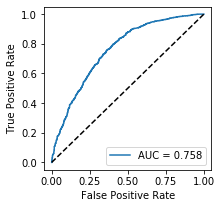

In [14]:
y_pred_rf = rf.predict_proba(x_test)[:, 1]
%matplotlib inline
plt.rcParams['figure.figsize'] = [3, 3]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
plt.plot(fpr_rf, tpr_rf, label='AUC = %0.3f' % roc_auc_score(y_test, y_pred_rf))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

No handles with labels found to put in legend.


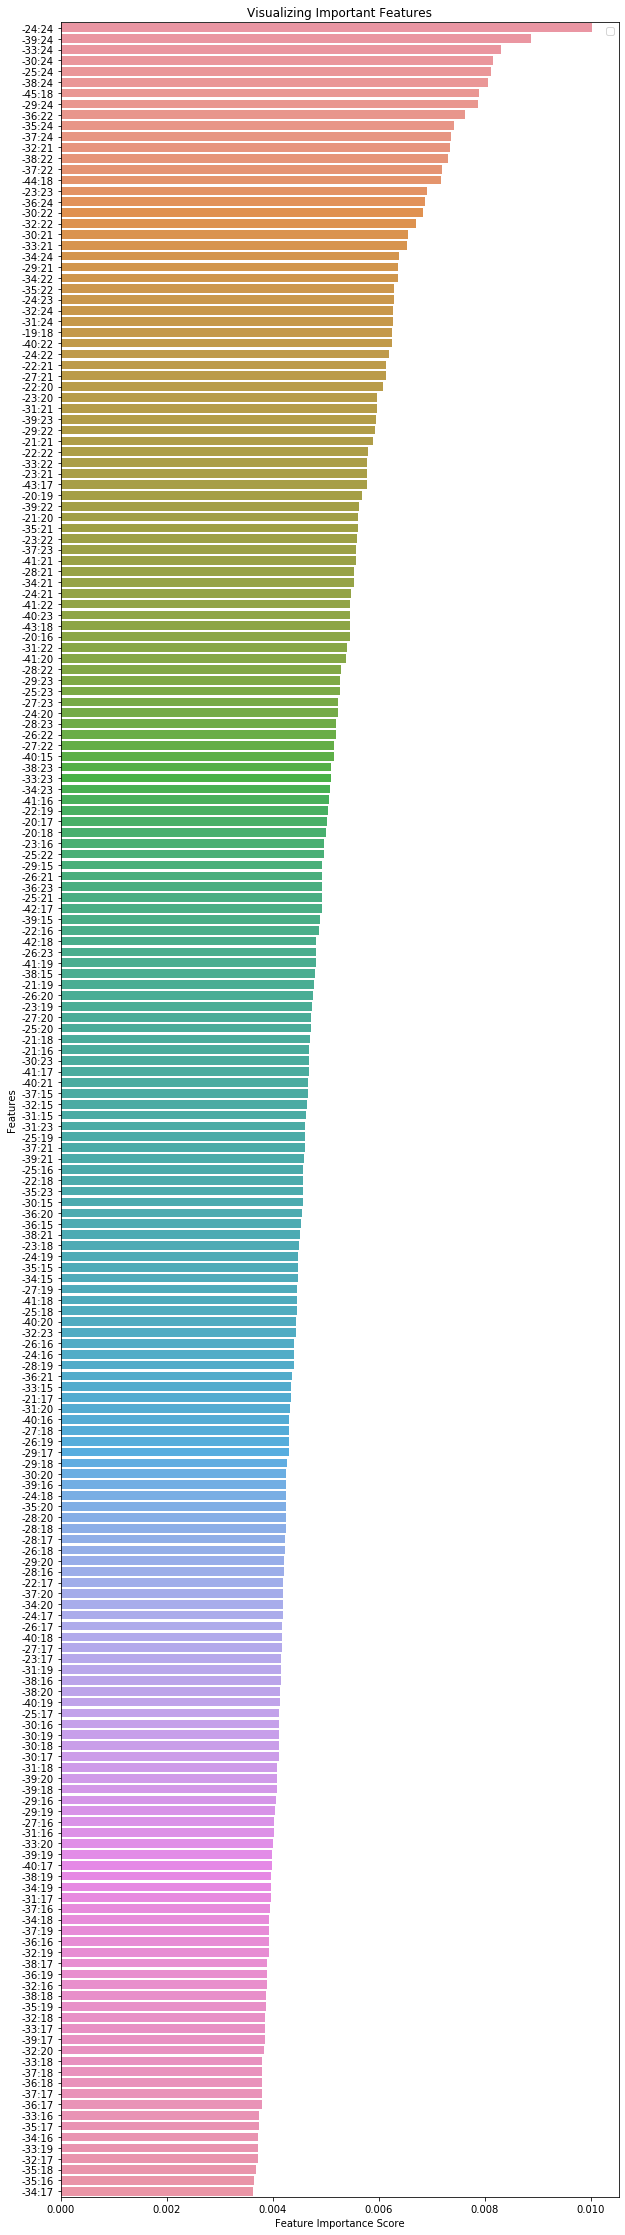

In [15]:
feature_imp = pd.Series(rf.feature_importances_,index=list(x)).sort_values(ascending=False)
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 40]
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()